### **Database Monitoring Script - Cocaine Seizures 2025 (Google Sheets)**
#### InSight Crime - MAD Unit 
June, 2025

##### Luis Felipe Villota Macías

---------------------



### Project Setup

#### Version Control

The project is created within a single GitHub repository ([FelipeVillota/db-check-cocaine-seizures](https://github.com/FelipeVillota/db-check-cocaine-seizures)). I keep the repository `private` with the possibility to give access to the online repo at any time. 

#### Reproducible Environment

In [91]:
# IMPORTANT
# To create venv
# python -m venv venv-db-watch

# To activate environment, run in Terminal:
# # (optional, temporary auth) 
# Set-ExecutionPolicy -Scope Process -ExecutionPolicy Bypass 
# venv-db-watch\Scripts\activate

# Then select respective kernel --> also install ipykernel package to connect to kernel

# Update list master list
# pip freeze > requirements.txt

In [92]:
# Checking venv-db-watch works
import sys
print(sys.executable)

c:\Users\USER\Desktop\ic\db-check-cocaine-seizures\venv-db-watch\Scripts\python.exe


#### Loading Libraries

In [93]:
# pip install --upgrade google-api-python-client google-auth-httplib2 google-auth-oauthlib pandas

In [94]:
import os
import re
import requests
import pandas as pd
from datetime import datetime
from google.oauth2 import service_account
from googleapiclient.discovery import build
import gspread
from google.oauth2.service_account import Credentials
from gspread_formatting import format_cell_ranges, CellFormat, Color
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

# pip freeze > requirements.txt

### Execution

#### Accessing the API

This creates a modular client (frontend) call that is able to extract the desired subset of data from the API server (backend); -and, make it easily reusable for future queries.


In [ ]:
# Configure Google Drive API

# Path to your service account key file
SERVICE_ACCOUNT_FILE = 'C:/Users/USER/Desktop/ic/llavero/summer-sector-439022-v6-2eafffbbfb90.json' # Update with your actual path or team credentials file

# Original (latest maintained) Google Sheet ID
ORIGINAL_SPREADSHEET_ID = '1t61MafCmnRe2QN082Bk1V0IxBSIW8UUqH1g5mULgb2o'

# Define the sheet tab or range to read
RANGE_NAME = '2025'

# Define scopes for Google Sheets and Drive API
SCOPES = ['https://www.googleapis.com/auth/spreadsheets', 
          'https://www.googleapis.com/auth/drive']


In [ ]:
# Authenticate and build both Sheets and Drive services
creds = service_account.Credentials.from_service_account_file(
    SERVICE_ACCOUNT_FILE, scopes=SCOPES)
sheet_service = build('sheets', 'v4', credentials=creds)
drive_service = build('drive', 'v3', credentials=creds)


In [119]:
# Create a copy of the original spreadsheet in Google Drive. IMPORTANT: Ommit this step if you want to work directly with the original spreadsheet.
 
# Create dated title for demo/test copy
today_str = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
copy_title = f'Validation Test - {today_str}'

# Create a copy with today's date
copy_body = {'name': copy_title, 'parents': ['root']}
copied_file = drive_service.files().copy(
    fileId=ORIGINAL_SPREADSHEET_ID,
    body=copy_body
).execute()

# Use the ID of the new copy for analysis
SPREADSHEET_ID = copied_file['id']

# Share with a personal Google account
drive_service.permissions().create(
    fileId=SPREADSHEET_ID,
    body={
        'type': 'user',
        'role': 'writer',
        'emailAddress': 'lvillota@insightcrime.org' 
    },
    fields='id'
).execute()

print(f"✅ Spreadsheet copied on {today_str}. New ID: {SPREADSHEET_ID}")

# URL
print(f"https://docs.google.com/spreadsheets/d/{SPREADSHEET_ID}")


✅ Spreadsheet copied on 2025-06-18 11:54:54. New ID: 1noD8DYXc7xu3Zo0xzjFLWd8MHKumYZh5lSPoOZZyBvA
https://docs.google.com/spreadsheets/d/1noD8DYXc7xu3Zo0xzjFLWd8MHKumYZh5lSPoOZZyBvA


In [120]:
# Load data
 
# Call the Sheets API to read data
sheet = service.spreadsheets()
result = sheet.values().get(spreadsheetId=SPREADSHEET_ID, range=RANGE_NAME).execute()
values = result.get('values', [])

# Convert to DataFrame for easier manipulation
df = pd.DataFrame(values[1:], columns=values[0])
print(df.head()) 

      Type   Time unit        Date Date 2  Year Month Day Duration  \
0  Seizure  Individual  2025-03-24         2025     3  24            
1  Seizure  Individual  2025-03-23         2025     3  23            
2  Seizure  Individual  2025-03-22         2025     3  22            
3  Seizure  Individual  2025-03-22         2025     3  22            
4  Seizure  Individual  2025-03-19         2025     3  19            

                       Type Drugs Quantity  ... Destition - department.state  \
0                         Cocaine       10  ...                                
1                         Cocaine      2.5  ...                                
2                         Cocaine     2619  ...                                
3  Other (explain in Description)     1240  ...                                
4                         Cocaine    16.05  ...                                

  Destition - Municipality/Port Destition 2 - Country  \
0                                        

#### Data Quality Report

In [ ]:
# Handle Missing/Invalid Values 
df = df.replace('', pd.NA)  # Convert empty strings to NA
df = df.replace(r'^\s*$', pd.NA, regex=True)  # Convert whitespace to NA
print("✓ Converted empty strings/whitespace to NA values")

✓ Converted empty strings/whitespace to NA values


In [ ]:
def get_dataframe_summary(df):
    # --- General DataFrame Info ---
    general_info = {
        "Shape": f"{df.shape[0]} rows × {df.shape[1]} cols",
        "Memory Usage": f"{df.memory_usage(deep=True).sum() / (1024 ** 2):.2f} MB",
        "Columns with NA": f"{df.isna().any().sum()} / {len(df.columns)}",
        "Duplicate Rows": f"{df.duplicated().sum()} ({(df.duplicated().mean() * 100):.1f}%)",
        "Numeric Columns": f"{df.select_dtypes(include='number').shape[1]}",
        "Categorical Columns": f"{df.select_dtypes(include=['object', 'category']).shape[1]}",
        "Datetime Columns": f"{df.select_dtypes(include='datetime').shape[1]}"
    }

    # --- Compute dropdown options per column ---
    dropdown_options_dict = {
        col: df[col].dropna().unique().tolist()
        for col in df.columns
    }

    # --- Column-Level Stats ---
    column_stats = pd.DataFrame({
        'Variable': df.columns,
        'Dtype': df.dtypes.values,
        'Unique_Count': df.nunique().values,
        'NA_Count': df.isna().sum().values,
        'NA_Percentage': (df.isna().mean() * 100).round(1).values,
        'Duplicate_Count': df.apply(lambda col: col.duplicated(keep=False).sum()).values,
        'Duplicate_Percentage': (df.apply(lambda col: col.duplicated(keep=False).mean()) * 100).round(1).values,
        'Unique_Values': df.apply(lambda x: x.drop_duplicates().tolist()).values,
        'Dropdown_Options': [dropdown_options_dict[col] for col in df.columns],
        'Dropdown_Option_Count': [len(dropdown_options_dict[col]) for col in df.columns]
    }).sort_values('Unique_Count', ascending=False)


    # Format percentages
    column_stats['NA_Percentage'] = column_stats['NA_Percentage'].astype(str) + '%'
    column_stats['Duplicate_Percentage'] = column_stats['Duplicate_Percentage'].astype(str) + '%'

    return general_info, column_stats

# Run the summary
general_info, column_stats = get_dataframe_summary(df)

# Print General Info
print("=== GENERAL DATAFRAME INFO ===")
for key, value in general_info.items():
    print(f"{key}: {value}")

# Display Column Stats (including dropdown options)
print("\n=== COLUMN-LEVEL STATISTICS WITH DROPDOWN OPTIONS ===")
display(column_stats)


=== GENERAL DATAFRAME INFO ===
Shape: 419 rows × 41 cols
Memory Usage: 1.10 MB
Columns with NA: 5 / 41
Duplicate Rows: 0 (0.0%)
Numeric Columns: 0
Categorical Columns: 41
Datetime Columns: 0

=== COLUMN-LEVEL STATISTICS WITH DROPDOWN OPTIONS ===


,Variable,Dtype,Unique_Count,NA_Count,NA_Percentage,Duplicate_Count,Duplicate_Percentage,Unique_Values,Dropdown_Options,Dropdown_Option_Count
35,Description,object,417,0,0.0%,4,1.0%,"[Spanish citizen, coming from Lisbon , was sto...","[Spanish citizen, coming from Lisbon , was sto...",417
39,Source link,object,400,1,0.2%,33,7.9%,[https://www.lanazione.it/firenze/cronaca/coca...,[https://www.lanazione.it/firenze/cronaca/coca...,400
9,Quantity,object,285,0,0.0%,202,48.2%,"[10, 2.5, 2619, 1240, 16.05, 65, 6600, 142, 55...","[10, 2.5, 2619, 1240, 16.05, 65, 6600, 142, 55...",285
17,Municipality/Port,object,265,0,0.0%,187,44.6%,"[Florence, Santo Domingo, Lake Maracaibo , Eag...","[Florence, Santo Domingo, Lake Maracaibo , Eag...",265
16,Department/State,object,220,0,0.0%,268,64.0%,"[, Zulia, Texas, Cáceres, Azores, Québec, Flor...","[, Zulia, Texas, Cáceres, Azores, Québec, Flor...",220
11,seizure_kgs,object,218,0,0.0%,250,59.7%,"[9, 2.5, 2619, 1240, 16.05, 65, 6600, 142, 250...","[9, 2.5, 2619, 1240, 16.05, 65, 6600, 142, 250...",218
2,Date,object,95,0,0.0%,402,95.9%,"[2025-03-24, 2025-03-23, 2025-03-22, 2025-03-1...","[2025-03-24, 2025-03-23, 2025-03-22, 2025-03-1...",95
24,Transit 1/Municipality,object,73,0,0.0%,358,85.4%,"[, Matapalo, Rio de Janeiro, Acapulco, Kingsto...","[, Matapalo, Rio de Janeiro, Acapulco, Kingsto...",73
23,Transit 1/Department,object,62,0,0.0%,370,88.3%,"[Lisbon, , Santo Domingo, Paris, Puntarenas, T...","[Lisbon, , Santo Domingo, Paris, Puntarenas, T...",62
15,Country,object,51,0,0.0%,399,95.2%,"[Italy, Dominican Republic, Venezuela, United ...","[Italy, Dominican Republic, Venezuela, United ...",51


Missing values per column:
Type                                 0
Time unit                            0
Date                                 2
Date 2                             408
Year                                 2
Month                                2
Day                                  3
Duration                           407
Type Drugs                           0
Quantity                             3
Weight unit                          2
seizure_kgs                        122
Modus Operandi/place of seizure      7
Sub MO                             389
Region                               0
Country                              3
Department/State                    36
Municipality/Port                  110
Origin country                     363
Origin Area                        397
Origin municipality                405
Transit 1/Region                   263
Transit 1/country                  250
Transit 1/Department               321
Transit 1/Municipality             33

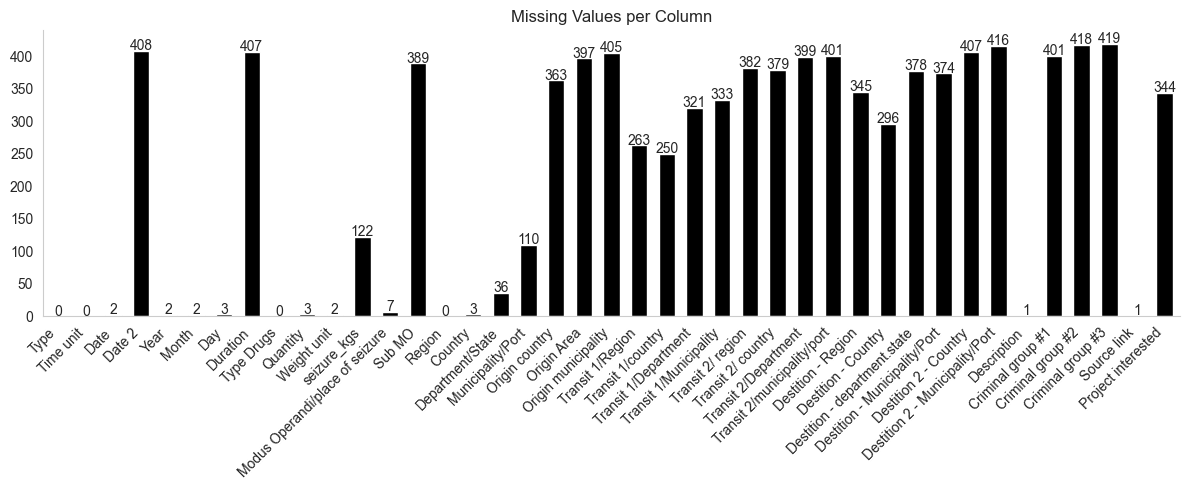

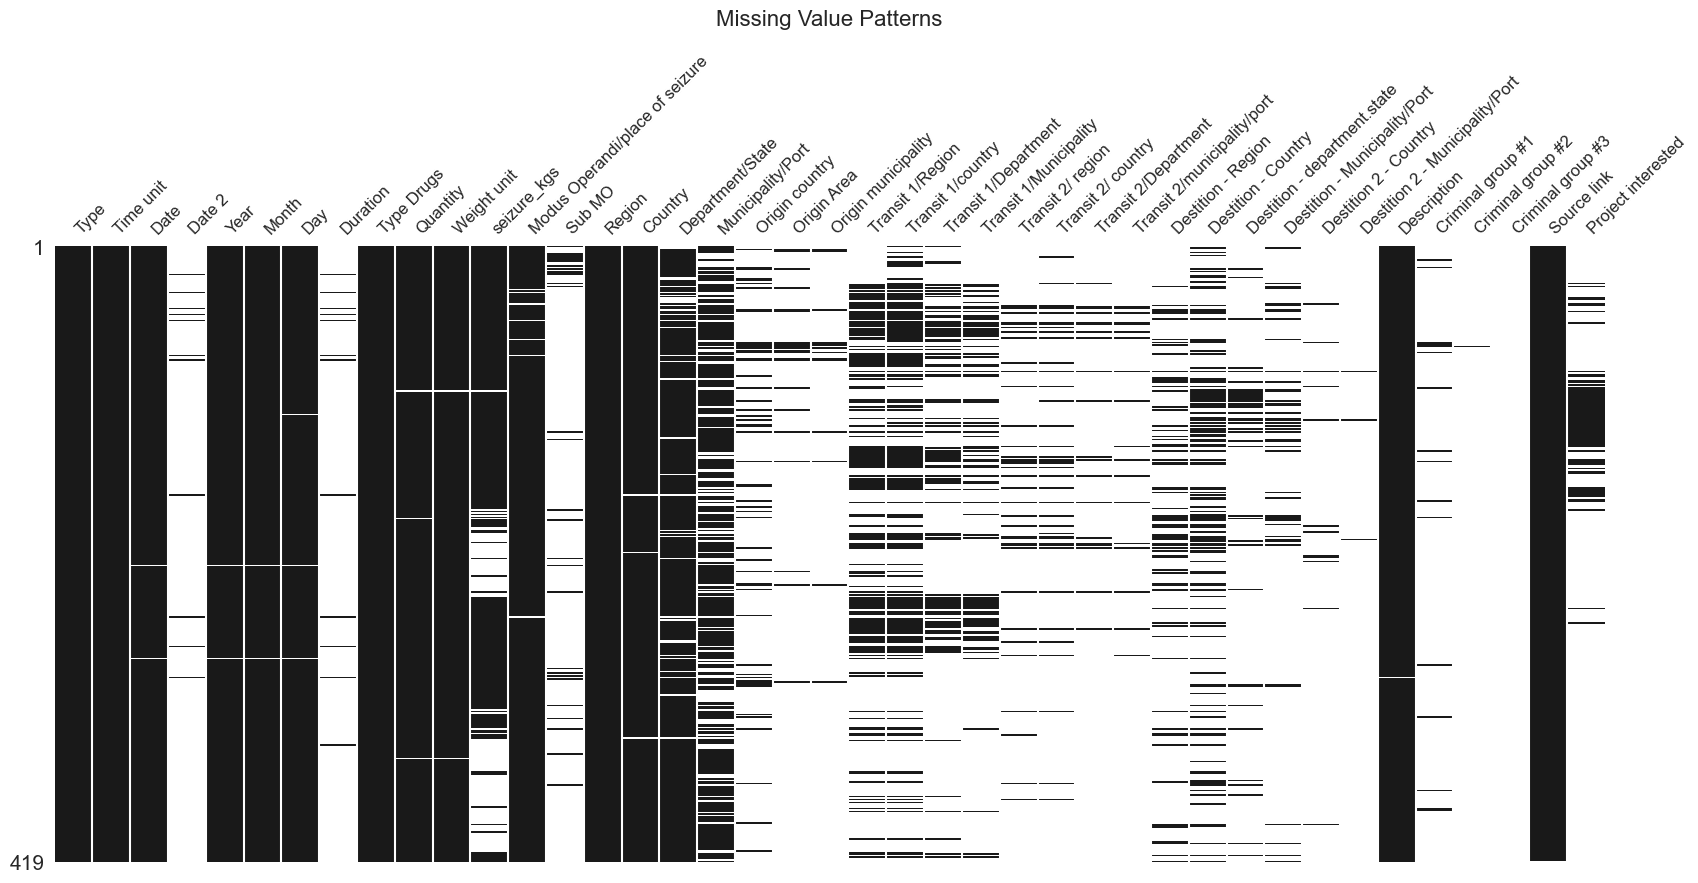

In [149]:
# Missing Data Analysis

missing_values = df.isnull().sum()
print(f"Missing values per column:\n{missing_values}\n")

# Visualization 1: Bar Chart
plt.figure(figsize=(12, 5))
ax = missing_values.plot(kind='bar', color="#000000", width=0.6)
ax.grid(False)
for i in ax.patches:
    ax.text(i.get_x() + i.get_width()/2, i.get_height()+1, 
            f'{int(i.get_height())}', 
            ha='center', fontsize=10)
plt.xticks(rotation=45, ha='right')
sns.despine()
plt.title("Missing Values per Column")
plt.tight_layout()
plt.show()

# Visualization 2: Missingno Matrix
msno.matrix(
    df,
    figsize=(20, 8),
    color=(0.1, 0.1, 0.1),
    sparkline=False,
    fontsize=12,
    labels=True
)
plt.title("Missing Value Patterns", fontsize=16, pad=20)
plt.show()

# Validation

In [ ]:
# Date must not be empty
def validate_dates(df, date_column='Date'):
    if date_column not in df.columns:
        print(f"❌ Column '{date_column}' not found")
        return
    
    # Check for empty dates
    empty_dates = df[df[date_column].isna()]
    
    if not empty_dates.empty:
        print(f"❌ Found {len(empty_dates)} rows with empty '{date_column}' dates:")
        print(empty_dates)
    else:
        print(f"✅ All '{date_column}' dates are filled")
         


In [ ]:
# Why is there Duration if there is no Date 2?  
def validate_duration(df, date_column='Date', date2_column='Date 2', duration_column='Duration'):
    if date_column not in df.columns or date2_column not in df.columns or duration_column not in df.columns:
        print(f"❌ One or more columns '{date_column}', '{date2_column}', or '{duration_column}' not found")
        return
    
    # Check for rows where Date 2 is empty but Duration is filled
    invalid_rows = df[(df[date2_column].isna()) & (df[duration_column].notna())]
    
    if not invalid_rows.empty:
        print(f"❌ Found {len(invalid_rows)} rows with '{duration_column}' filled but '{date2_column}' empty:")
        print(invalid_rows)
    else:
        print(f"✅ All '{duration_column}' values are valid with respect to '{date2_column}'")

### Direct Actions on Sheet (Demo)

In [165]:
# Update a column name directly in Google Sheets
def update_column_name(old_name, new_name):
    # Get headers
    headers = sheet.values().get(spreadsheetId=SPREADSHEET_ID, range='2025!1:1').execute()['values'][0]
    
    # Find and update column
    if old_name in headers:
        col_index = headers.index(old_name)
        col_letter = chr(65 + col_index)  # Convert to A, B, C...
        
        # Update in sheet
        sheet.values().update(
            spreadsheetId=SPREADSHEET_ID,
            range=f'2025!{col_letter}1',
            valueInputOption='RAW',
            body={'values': [[new_name]]}
        ).execute()
        
        print(f"✅ '{old_name}' → '{new_name}'")
    else:
        print(f"❌ '{old_name}' not found")

# Function usage
update_column_name('Type', 'TIPO')

# Refresh DataFrame
result = sheet.values().get(spreadsheetId=SPREADSHEET_ID, range=RANGE_NAME).execute()
values = result.get('values', [])
df = pd.DataFrame(values[1:], columns=values[0])

❌ 'Type' not found


In [166]:
# Format dates directly in Google Sheets
def format_dates(date_column_name='Date'):
    # Get all data
    result = sheet.values().get(spreadsheetId=SPREADSHEET_ID, range=RANGE_NAME).execute()
    values = result.get('values', [])
    
    if not values:
        print("❌ No data found")
        return
    
    headers = values[0]
    if date_column_name not in headers:
        print(f"❌ '{date_column_name}' column not found")
        return
    
    col_index = headers.index(date_column_name)
    col_letter = chr(65 + col_index)
    
    # Process dates
    updated_values = []
    for i, row in enumerate(values[1:], 2):  # Start from row 2
        if col_index < len(row) and row[col_index]:
            try:
                # Parse date (assuming YYYY-MM-DD format)
                date_obj = datetime.strptime(row[col_index], "%Y-%m-%d")
                # Format to DD-MM-YYYY
                formatted_date = date_obj.strftime("%d-%m-%Y")
                updated_values.append([formatted_date])
            except ValueError:
                # Keep original if can't parse
                updated_values.append([row[col_index]])
        else:
            updated_values.append([''])
    
    # Update the entire date column
    if updated_values:
        sheet.values().update(
            spreadsheetId=SPREADSHEET_ID,
            range=f'2025!{col_letter}2:{col_letter}{len(updated_values)+1}',
            valueInputOption='RAW',
            body={'values': updated_values}
        ).execute()
        
        print(f"✅ Dates formatted to DD-MM-YYYY in column {col_letter}")

# Function usage
format_dates('Date')  # or whatever your date column is called

✅ Dates formatted to DD-MM-YYYY in column C
